# Analyzing images
Comparing networks of dense layers to convolutional networks on simple image analyses.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import tensorflow.keras as ks

2023-04-08 17:19:50.163840: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 17:19:50.210130: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 17:19:50.211083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 17:19:51.044346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Generator functions for sample images
Defining functions that generate images with circles/squares in it. See docstring for details

In [3]:
def create_image_w_square(im_size_x=200, im_size_y=200, fill_color=[255, 255, 255],
                          sq_size=30, sq_color=[255, 128, 0]):
    '''Creates a numpy array with three dimensions, which represents an color image.
    The picture will hold a square on an arbitary position.
    Size of image and square, as well as the color of background and square my be specified.
    Besides the image the position of the square (its center position) and its area in pixels is returned'''
    # Generating image with background color
    image = np.full(shape=(im_size_x, im_size_y, 3), fill_value=fill_color)
    # Determing random position for square
    coord_x = np.random.randint(low=0, high=(im_size_x - sq_size))
    coord_y = np.random.randint(low=0, high=(im_size_y - sq_size))
    # Filling square in the image by scpecifying its color value on all three layers
    for i in range(3):
        image[coord_x:coord_x + sq_size, coord_y:coord_y + sq_size, i] = sq_color[i]
    return image, [coord_x + sq_size/2, coord_y + sq_size/2], sq_size**2

def create_image_w_circle(im_size_x=200, im_size_y=200, fill_color=[255, 255, 255],
                          circle_r=17, circle_color=[255, 128, 0]):
    '''Creates a numpy array with three dimensions, which represents an color image.
    The picture will hold a circle on an arbitary position.
    Size of image and circle, as well as the color of background and circle my be specified.
    Besides the image the position of the circle and its area in pixels is returned'''
    # Generating image with background color
    image = np.full(shape=(im_size_x, im_size_y, 3), fill_value=fill_color)
    # Determing coordinates for center of circle
    coord_x = np.random.randint(low=circle_r, high=(im_size_x - circle_r))
    coord_y = np.random.randint(low=circle_r, high=(im_size_y - circle_r))
    # Filling circle in the image by specifying its color value on all three layers
    for i in range(3):
        # Creating a meshgrid of image size and than calculate from that, whether position is in circle
        mesh = np.meshgrid(range(im_size_y), range(im_size_x))
        mesh[0] -= coord_y
        mesh[1] -= coord_x
        mask = np.sqrt(mesh[0]**2 + mesh[1]**2) < circle_r
        # Write new color on image, where pixels are within radius of circle
        image[mask, i] = circle_color[i]
    return image, [coord_x, coord_y], np.pi*circle_r**2

def samples_squares(sample_size=2300, im_sizex=60, im_size_y=60, fill_color=[255, 255, 255],
                    sq_color='random', sq_size=[30, 30]):
    '''Function return list of samples composed of images generated by function 
    "create_image_w_square()" and list of list containing x- and y-position of center of square and area of
    square (in px). See doc string of this function for details of images.
    Define size of square in image as a list of min and max value.
    Fill_color (background of image) and sq_color (color of square) are lists of three
    color values or string "random" for choosing random color in every image.'''
    samples = []
    target = []
    for i in range(sample_size):
        # Defining color of square for this iteration
        pattern_color = []
        if (sq_color == 'random'):
            # Choosing random color
            for j in range(3):
                pattern_color.append(np.random.randint(low=0, high=255))
        else:
            # sq_color already contains color value
            pattern_color = sq_color
        # Defining color of background for this iteration
        background_color = []
        if (fill_color == 'random'):
            # Choosing random color
            for j in range(3):
                background_color.append(np.random.randint(low=0, high=255))
        else:
            # fill_color already contained color value
            background_color = fill_color
        # Determing size of square for this iteration
        pattern_size = np.random.randint(low=sq_size[0], high=sq_size[1] + 1)
        # Calling image creator function and append image and its informations to samples resp. target
        image, coord, area = create_image_w_square(im_size_x=60, im_size_y=60, fill_color=background_color,
                                               sq_color=pattern_color, sq_size=pattern_size)
        samples.append(image)
        target.append([coord[0], coord[1], area])
    return samples, target

# Sample preprocessing (normalizing colors on 0 to 1 values)
def preprocessing(samples):
    samples_processed = np.array(samples)
    samples_processed //= 255
    return samples_processed

## Generating sample of images with same colored pattern
200 x 200 pixel images, containing same sized squares and circles.

In [3]:
# Defining number of samples
sample_size = 2300

# Filling list with sample images, which contain squares or circles. Holding information about 
# circle or quare in seperate array (dummy columns).
samples = []
target = np.zeros(shape=(sample_size, 2))
for i in range(sample_size):
    if np.random.randint(low=0, high=2):
        image, *_ = create_image_w_square(im_size_x=60, im_size_y=60)
        samples.append(image)
        target[i, 0] = 1
    else:
        image, *_ = create_image_w_circle(im_size_x=60, im_size_y=60)
        samples.append(image)
        target[i, 1] = 1

# 1) Initializing and training of net to distinguish squares from circles
1. Attempt: Dense neuronal net
2. Attempt: Convolutional neuronal net

## 1A) Training a dense net

In [4]:
#Defining net
Net_dense = ks.Sequential()
Net_dense.add(ks.layers.Dense(1000, activation='relu', input_shape=(10800,))) # Hidden layer
Net_dense.add(ks.layers.Dense(50, activation='relu')) # Hidden layer
Net_dense.add(ks.layers.Dense(2, activation='softmax')) # Output layer

# Compiling defined net
Net_dense.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics='accuracy') 

In [5]:
samples_train = preprocessing(samples)

In [81]:
# Training the net, defining portion of samples as validation data set
history = Net_dense.fit(samples_train, target, batch_size=50, validation_split=0.1, epochs=50)

Epoch 1/50
42/42 [==============================] - 6s 126ms/step - loss: 5.4407 - accuracy: 0.5159 - val_loss: 0.8224 - val_accuracy: 0.5348
Epoch 2/50
42/42 [==============================] - 4s 104ms/step - loss: 0.9302 - accuracy: 0.5329 - val_loss: 0.6598 - val_accuracy: 0.6174
Epoch 3/50
42/42 [==============================] - 4s 103ms/step - loss: 0.8096 - accuracy: 0.5454 - val_loss: 0.7311 - val_accuracy: 0.6000
Epoch 4/50
42/42 [==============================] - 4s 105ms/step - loss: 0.7739 - accuracy: 0.5585 - val_loss: 0.8624 - val_accuracy: 0.4957
Epoch 5/50
42/42 [==============================] - 4s 103ms/step - loss: 0.7280 - accuracy: 0.5686 - val_loss: 0.8055 - val_accuracy: 0.4957
Epoch 6/50
42/42 [==============================] - 4s 102ms/step - loss: 0.7936 - accuracy: 0.5589 - val_loss: 0.6727 - val_accuracy: 0.6043
Epoch 7/50
42/42 [==============================] - 5s 109ms/step - loss: 0.8539 - accuracy: 0.5643 - val_loss: 0.6608 - val_accuracy: 0.6174
Epoch 

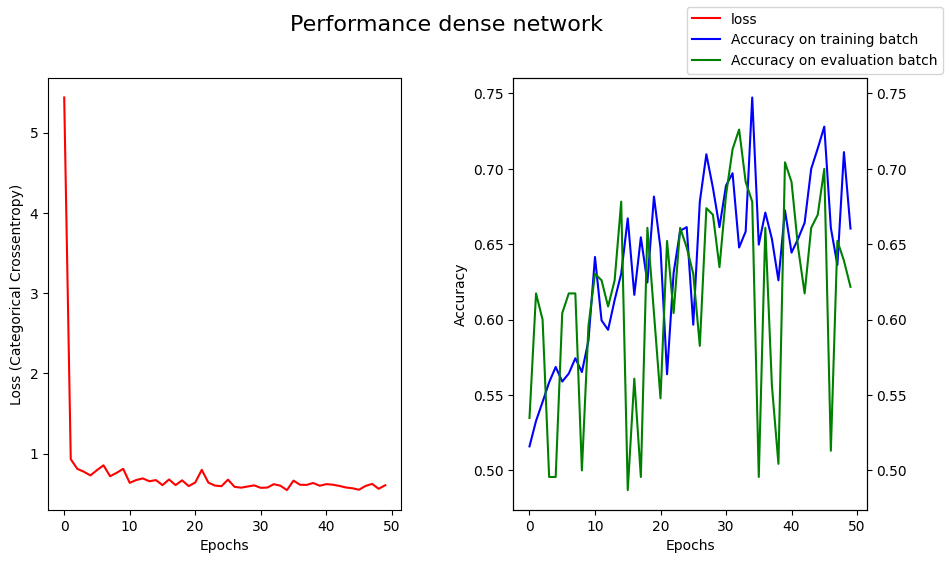

In [102]:
# Plotting loss-function and accuracy on training and evaluation batch. 
plt.rcParams["figure.figsize"] = [10, 6] # Defining figure size
fig, axs = plt.subplots(1, 2) # Plot contains two subplots
fig.tight_layout(pad=5) # For spacing between subplots

axs[0].set_ylabel('Loss (Categorical Crossentropy)') # left plot y-axis label
axs[0].set_xlabel('Epochs') # left plot x-axis label
axs[0].plot(history.history['loss'], color='red', label='loss') # plot loss-function in left figure

axs[1].set_ylabel('Accuracy') # right plot y-axis label
axs[1].set_xlabel('Epochs') # right plot x-axis label
ax2 = axs[1].twinx() # generate second axis to commonly plot accuracy on training and evaluation batch
ax2.sharey(axs[1]) # Both share y-axis
axs[1].plot(history.history['accuracy'], color='blue'
            , label='Accuracy on training batch') # Plot accuracy on training batch with blue color 
ax2.plot(history.history['val_accuracy'], color='green'
         , label='Accuracy on evaluation batch') # Plot accuracy on evaluation batch with green color
fig.suptitle('Performance dense network', fontsize=16)
fig.legend()

Conclusion: The network is learning, but slowly. Too slow for performance of my system.

## 1B) Training a convolutional network on same problem

In [6]:
# 2. Attempt: Convolutional neuronal network
Net_conv = ks.Sequential()
Net_conv.add(ks.layers.Conv2D(input_shape=(samples[0].shape), filters=20, kernel_size=[7, 7]
                              , activation='tanh', padding='same'))
Net_conv.add(ks.layers.AveragePooling2D(pool_size=6))
Net_conv.add(ks.layers.Conv2D(filters=10, kernel_size=[7, 7]
                              , activation='tanh', padding='same'))
Net_conv.add(ks.layers.Flatten())
Net_conv.add(ks.layers.Dense(50, activation='tanh'))
Net_conv.add(ks.layers.Dense(2, activation='softmax'))

Net_conv.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics='accuracy')

In [7]:
samples_train_conv = preprocessing(samples)

In [8]:
history_conv = Net_conv.fit(samples_train_conv, target, validation_split=0.1, epochs=12)

Epoch 1/12
65/65 [==============================] - 6s 78ms/step - loss: 0.7387 - accuracy: 0.5184 - val_loss: 0.6705 - val_accuracy: 0.5870
Epoch 2/12
65/65 [==============================] - 5s 73ms/step - loss: 0.6807 - accuracy: 0.5565 - val_loss: 0.6489 - val_accuracy: 0.6478
Epoch 3/12
65/65 [==============================] - 5s 72ms/step - loss: 0.6810 - accuracy: 0.5725 - val_loss: 0.6481 - val_accuracy: 0.6652
Epoch 4/12
65/65 [==============================] - 5s 77ms/step - loss: 0.6640 - accuracy: 0.5952 - val_loss: 0.6451 - val_accuracy: 0.6870
Epoch 5/12
65/65 [==============================] - 5s 72ms/step - loss: 0.6600 - accuracy: 0.6077 - val_loss: 0.5686 - val_accuracy: 0.7348
Epoch 6/12
65/65 [==============================] - 5s 76ms/step - loss: 0.4242 - accuracy: 0.8464 - val_loss: 0.1876 - val_accuracy: 0.9913
Epoch 7/12
65/65 [==============================] - 5s 74ms/step - loss: 0.0965 - accuracy: 0.9990 - val_loss: 0.0511 - val_accuracy: 1.0000
Epoch 8/12
65

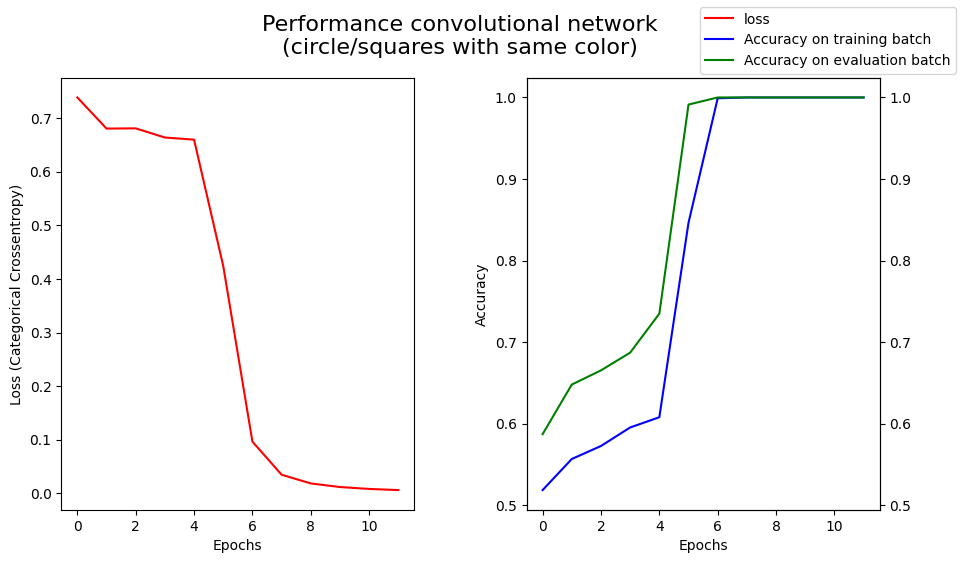

In [9]:
# Plotting loss-function and accuracy on training and evaluation batch. 
plt.rcParams["figure.figsize"] = [10, 6] # Defining figure size
fig, axs = plt.subplots(1, 2) # Plot contains two subplots
fig.tight_layout(pad=5) # For spacing between subplots

axs[0].set_ylabel('Loss (Categorical Crossentropy)') # left plot y-axis label
axs[0].set_xlabel('Epochs') # left plot x-axis label
axs[0].plot(history_conv.history['loss'], color='red', label='loss') # plot loss-function in left figure

axs[1].set_ylabel('Accuracy') # right plot y-axis label
axs[1].set_xlabel('Epochs') # right plot x-axis label
ax2 = axs[1].twinx() # generate second axis to commonly plot accuracy on training and evaluation batch
ax2.sharey(axs[1]) # Both share y-axis
axs[1].plot(history_conv.history['accuracy'], color='blue'
            , label='Accuracy on training batch') # Plot accuracy on training batch with blue color 
ax2.plot(history_conv.history['val_accuracy'], color='green'
         , label='Accuracy on evaluation batch') # Plot accuracy on evaluation batch with green color
fig.suptitle('Performance convolutional network\n(circle/squares with same color)', fontsize=16)
fig.legend()

Conclusion: Convolutional net learns much quicker, in this case calculations for one epoch took approx. same time as for dense network, but results werde very good already after 6 epochs.

##  2) Performance of convolutional network on images with different colors/noise

### 2A) Creating a sample set with random color for square and circle

In [26]:
# Defining number of samples
sample_size = 2300

# Filling list with sample images, which contain squares or circles. Holding information about 
# circle or quare in seperate array (dummy columns). Random color of squares and circles
samples_2 = []
target_2 = []
for i in range(sample_size):
    # Choosing random color
    pattern_color = []
    for j in range(3):
        pattern_color.append(np.random.randint(low=0, high=255))
    if np.random.randint(low=0, high=2):
        image, *_ = create_image_w_square(im_size_x=60, im_size_y=60, sq_color=pattern_color)
        samples_2.append(image)
        target_2.append(np.array([1, 0]))
    else:
        image, *_ = create_image_w_circle(im_size_x=60, im_size_y=60, circle_color=pattern_color)
        samples_2.append(image)
        target_2.append(np.array([0, 1]))


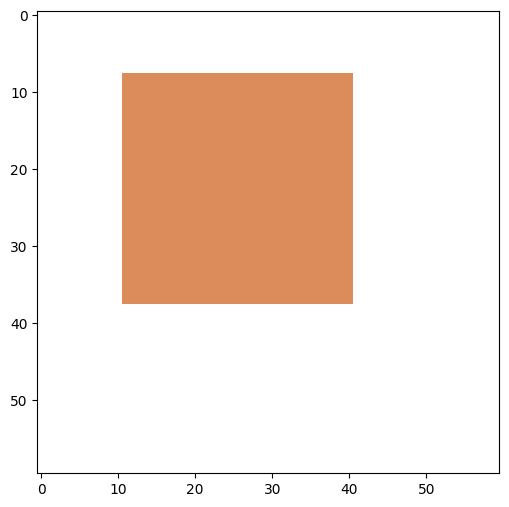

In [27]:
# Displaying example of sample 
plt.imshow(samples_2[6])

In [28]:
# Defining convolutional network of same layout as befor
Net_conv2 = ks.Sequential()
Net_conv2.add(ks.layers.Conv2D(input_shape=(samples[0].shape), filters=20, kernel_size=[7, 7]
                              , activation='tanh', padding='same')) # Hidden layer conv. with kernel 7x7
Net_conv2.add(ks.layers.AveragePooling2D(pool_size=6)) # Hidden layer to reduce by factor of 6 each dimension
Net_conv2.add(ks.layers.Conv2D(filters=10, kernel_size=[7, 7] # Hidden layer conv. kernel 7x7
                              , activation='tanh', padding='same'))
Net_conv2.add(ks.layers.Flatten()) # Layer to flatten all convolutional filters, so dense layers can follow
Net_conv2.add(ks.layers.Dense(50, activation='tanh')) # Hidden dense layer
Net_conv2.add(ks.layers.Dense(2, activation='softmax')) # Output layer: one hot encoding

Net_conv2.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics='accuracy')

In [29]:
# Normalizing colors, converting target to numpy-array
samples_train_2 = preprocessing(samples_2)
target_train_2 = np.array(target_2)

In [30]:
# Train network
history_conv2 = Net_conv2.fit(samples_train_2, target_train_2, validation_split=0.1, epochs=12)

Epoch 1/12
65/65 [==============================] - 6s 82ms/step - loss: 0.7139 - accuracy: 0.5329 - val_loss: 0.6933 - val_accuracy: 0.5391
Epoch 2/12
65/65 [==============================] - 5s 78ms/step - loss: 0.6761 - accuracy: 0.5773 - val_loss: 0.6788 - val_accuracy: 0.5696
Epoch 3/12
65/65 [==============================] - 5s 74ms/step - loss: 0.6636 - accuracy: 0.5952 - val_loss: 0.6925 - val_accuracy: 0.5870
Epoch 4/12
65/65 [==============================] - 5s 73ms/step - loss: 0.6262 - accuracy: 0.6449 - val_loss: 0.5747 - val_accuracy: 0.7913
Epoch 5/12
65/65 [==============================] - 5s 72ms/step - loss: 0.4048 - accuracy: 0.8671 - val_loss: 0.1924 - val_accuracy: 0.9870
Epoch 6/12
65/65 [==============================] - 5s 79ms/step - loss: 0.0904 - accuracy: 0.9986 - val_loss: 0.0464 - val_accuracy: 1.0000
Epoch 7/12
65/65 [==============================] - 5s 76ms/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 1.0000
Epoch 8/12
65

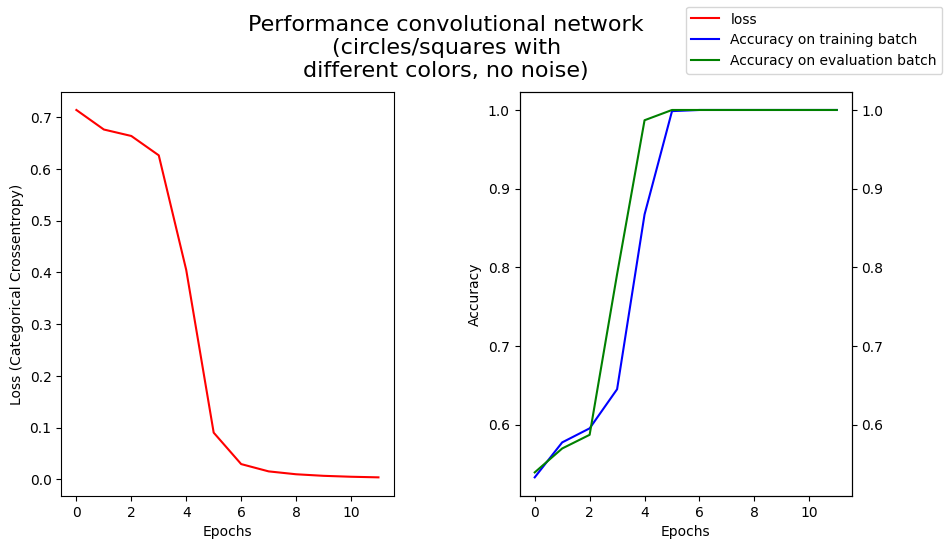

In [31]:
# Plotting loss-function and accuracy on training and evaluation batch. 
plt.rcParams["figure.figsize"] = [10, 6] # Defining figure size
fig, axs = plt.subplots(1, 2) # Plot contains two subplots
fig.tight_layout(pad=6) # For spacing between subplots

axs[0].set_ylabel('Loss (Categorical Crossentropy)') # left plot y-axis label
axs[0].set_xlabel('Epochs') # left plot x-axis label
axs[0].plot(history_conv2.history['loss'], color='red', label='loss') # plot loss-function in left figure

axs[1].set_ylabel('Accuracy') # right plot y-axis label
axs[1].set_xlabel('Epochs') # right plot x-axis label
ax2 = axs[1].twinx() # generate second axis to commonly plot accuracy on training and evaluation batch
ax2.sharey(axs[1]) # Both share y-axis
axs[1].plot(history_conv2.history['accuracy'], color='blue'
            , label='Accuracy on training batch') # Plot accuracy on training batch with blue color 
ax2.plot(history_conv2.history['val_accuracy'], color='green'
         , label='Accuracy on evaluation batch') # Plot accuracy on evaluation batch with green color
fig.suptitle('Performance convolutional network\n(circles/squares with\ndifferent colors, no noise)', fontsize=16)
fig.legend()

Conclusion: Trainingof net is comparable fast as with same color pattern.

### 2B) Add noise to same sample as in 2A)

In [32]:
# Function to add some percentage of noise (pixel with random color) to one image
def add_noise_image(image, noise_frac):
    no_px_modify = np.int_(len(image.flatten()) * noise_frac) # calculate how many pixels to modify
    for i in range(no_px_modify):
        coord_x = np.random.randint(low=0, high=image.shape[1]) # choose x and y position randomly
        coord_y = np.random.randint(low=0, high=image.shape[0])
        for j in range(3):
            image[coord_x, coord_y, j] = np.random.randint(low=0, high=255) # fill all 3 layers 
            # at choosen position with random value to obtain random color value
    return(image)

# Function to add noise to a list of images
def add_noise(samples, noise_frac):
    for i, image in enumerate(samples):
        image = add_noise_image(image, noise_frac)
    return(samples)

# Adding noise to sample set
samples_3 = add_noise(samples_2, 0.3) # Randomizing 30% of all pixel

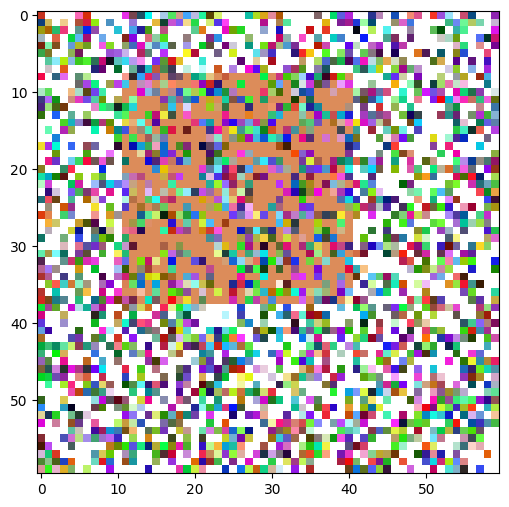

In [33]:
# Displaying example of sample 
plt.imshow(samples_2[6])

In [34]:
# Defining convolutional network of same layout as befor
Net_conv3 = ks.Sequential()
Net_conv3.add(ks.layers.Conv2D(input_shape=(samples[0].shape), filters=20, kernel_size=[7, 7]
                              , activation='tanh', padding='same')) # Hidden layer conv. with kernel 7x7
Net_conv3.add(ks.layers.AveragePooling2D(pool_size=6)) # Hidden layer to reduce by factor of 6 each dimension
Net_conv3.add(ks.layers.Conv2D(filters=10, kernel_size=[7, 7] # Hidden layer conv. kernel 7x7
                              , activation='tanh', padding='same'))
Net_conv3.add(ks.layers.Flatten()) # Layer to flatten all convolutional filters, so dense layers can follow
Net_conv3.add(ks.layers.Dense(50, activation='tanh')) # Hidden dense layer
Net_conv3.add(ks.layers.Dense(2, activation='softmax')) # Output layer: one hot encoding

Net_conv3.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics='accuracy')

In [35]:
# Normalizing colors values, converting target to numpy_array
samples_train_3 = preprocessing(samples_3)
target_train_3 = np.array(target_2)

In [36]:
# Train network
history_conv3 = Net_conv3.fit(samples_train_3, target_train_3, validation_split=0.1, epochs=40)

Epoch 1/40
65/65 [==============================] - 6s 77ms/step - loss: 0.6950 - accuracy: 0.5604 - val_loss: 0.6626 - val_accuracy: 0.6174
Epoch 2/40
65/65 [==============================] - 5s 78ms/step - loss: 0.6624 - accuracy: 0.5932 - val_loss: 0.6939 - val_accuracy: 0.5130
Epoch 3/40
65/65 [==============================] - 5s 73ms/step - loss: 0.6629 - accuracy: 0.5903 - val_loss: 0.6868 - val_accuracy: 0.5826
Epoch 4/40
65/65 [==============================] - 5s 70ms/step - loss: 0.6487 - accuracy: 0.6246 - val_loss: 0.6883 - val_accuracy: 0.5957
Epoch 5/40
65/65 [==============================] - 5s 73ms/step - loss: 0.6327 - accuracy: 0.6386 - val_loss: 0.7100 - val_accuracy: 0.5261
Epoch 6/40
65/65 [==============================] - 5s 73ms/step - loss: 0.6249 - accuracy: 0.6570 - val_loss: 0.7532 - val_accuracy: 0.5000
Epoch 7/40
65/65 [==============================] - 5s 70ms/step - loss: 0.6196 - accuracy: 0.6512 - val_loss: 0.7428 - val_accuracy: 0.5130
Epoch 8/40
65

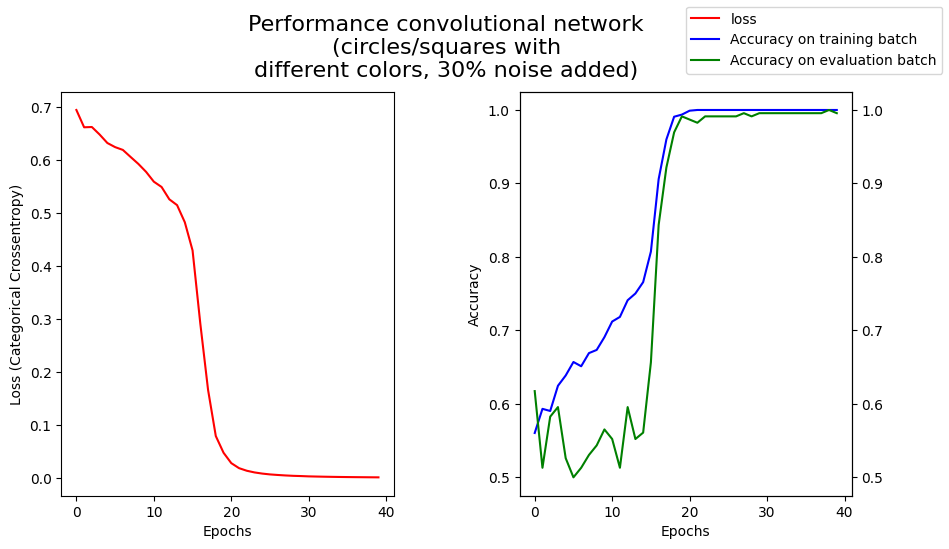

In [52]:
# Plotting loss-function and accuracy on training and evaluation batch. 
plt.rcParams["figure.figsize"] = [10, 6] # Defining figure size
fig, axs = plt.subplots(1, 2) # Plot contains two subplots
fig.tight_layout(pad=6) # For spacing between subplots

axs[0].set_ylabel('Loss (Categorical Crossentropy)') # left plot y-axis label
axs[0].set_xlabel('Epochs') # left plot x-axis label
axs[0].plot(history_conv3.history['loss'], color='red', label='loss') # plot loss-function in left figure

axs[1].set_ylabel('Accuracy') # right plot y-axis label
axs[1].set_xlabel('Epochs') # right plot x-axis label
ax2 = axs[1].twinx() # generate second axis to commonly plot accuracy on training and evaluation batch
ax2.sharey(axs[1]) # Both share y-axis
axs[1].plot(history_conv3.history['accuracy'], color='blue'
            , label='Accuracy on training batch') # Plot accuracy on training batch with blue color 
ax2.plot(history_conv3.history['val_accuracy'], color='green'
         , label='Accuracy on evaluation batch') # Plot accuracy on evaluation batch with green color
fig.suptitle('Performance convolutional network\n(circles/squares with\ndifferent colors, 30% noise added)', fontsize=16)
fig.legend()

Conclusion: 30% of noise significantly slowes down learning progress of net.

# 3) Distinguishing on samples that containe different sized squares/circles

In [67]:
# Creating samples of random sized and colored circles and squares
# Defining number of samples
sample_size = 2300

# Filling list with sample images, which contain squares or circles. Holding information about 
# circle or quare in seperate array (dummy columns). Random color of squares and circles, random size
samples_4 = []
target_4 = []
for i in range(sample_size):
    # Choosing random color
    pattern_color = []
    for j in range(3):
        pattern_color.append(np.random.randint(low=0, high=255))
    if np.random.randint(low=0, high=2):
        image, *_ = create_image_w_square(im_size_x=60, im_size_y=60, sq_color=pattern_color, 
                                          sq_size=np.random.randint(low=9, high=40))
        samples_4.append(image)
        target_4.append(np.array([1, 0]))
    else:
        image, *_ = create_image_w_circle(im_size_x=60, im_size_y=60, circle_color=pattern_color, 
                                          circle_r=np.random.randint(low=5, high=23))
        samples_4.append(image)
        target_4.append(np.array([0, 1]))

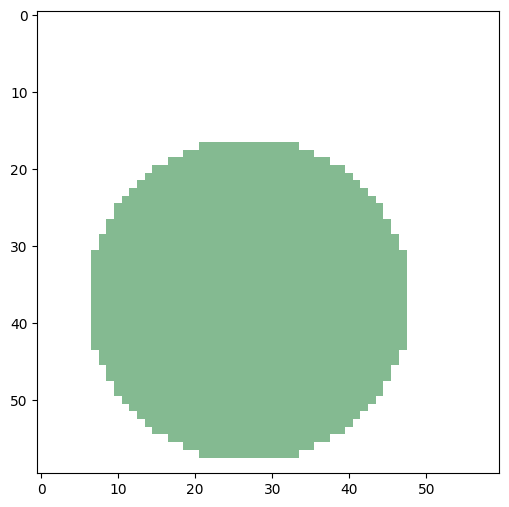

In [75]:
# Displaying example of sample data
plt.imshow(samples_4[7])

In [92]:
# Defining convolutional network of same layout as befor
Net_conv4 = ks.Sequential()
Net_conv4.add(ks.layers.Conv2D(input_shape=(samples[0].shape), filters=20, kernel_size=[7, 7]
                              , activation='tanh', padding='same')) # Hidden layer conv. with kernel 7x7
Net_conv4.add(ks.layers.AveragePooling2D(pool_size=6)) # Hidden layer to reduce by factor of 6 each dimension
Net_conv4.add(ks.layers.Conv2D(filters=10, kernel_size=[7, 7] # Hidden layer conv. kernel 7x7
                              , activation='tanh', padding='same'))
Net_conv4.add(ks.layers.Flatten()) # Layer to flatten all convolutional filters, so dense layers can follow
Net_conv4.add(ks.layers.Dense(50, activation='tanh')) # Hidden dense layer
Net_conv4.add(ks.layers.Dense(2, activation='softmax')) # Output layer: one hot encoding

Net_conv4.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics='accuracy')

In [76]:
# Sample preprocessing: normalizing colors to values 0 to 1, converting target to array
samples_train_4 = preprocessing(samples_4)
target_train_4 = np.array(target_4)

In [93]:
history_4 = Net_conv4.fit(samples_train_4, target_train_4, validation_split=0.1, epochs=40)

Epoch 1/40
65/65 [==============================] - 6s 78ms/step - loss: 0.7686 - accuracy: 0.4918 - val_loss: 0.6966 - val_accuracy: 0.4957
Epoch 2/40
65/65 [==============================] - 4s 68ms/step - loss: 0.6895 - accuracy: 0.5290 - val_loss: 0.6912 - val_accuracy: 0.5130
Epoch 3/40
65/65 [==============================] - 5s 70ms/step - loss: 0.6925 - accuracy: 0.5488 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 4/40
65/65 [==============================] - 4s 68ms/step - loss: 0.6793 - accuracy: 0.5570 - val_loss: 0.7087 - val_accuracy: 0.5391
Epoch 5/40
65/65 [==============================] - 5s 79ms/step - loss: 0.6817 - accuracy: 0.5671 - val_loss: 0.6886 - val_accuracy: 0.5435
Epoch 6/40
65/65 [==============================] - 6s 88ms/step - loss: 0.6698 - accuracy: 0.5884 - val_loss: 0.7223 - val_accuracy: 0.5478
Epoch 7/40
65/65 [==============================] - 6s 95ms/step - loss: 0.6767 - accuracy: 0.5797 - val_loss: 0.7635 - val_accuracy: 0.5000
Epoch 8/40
65

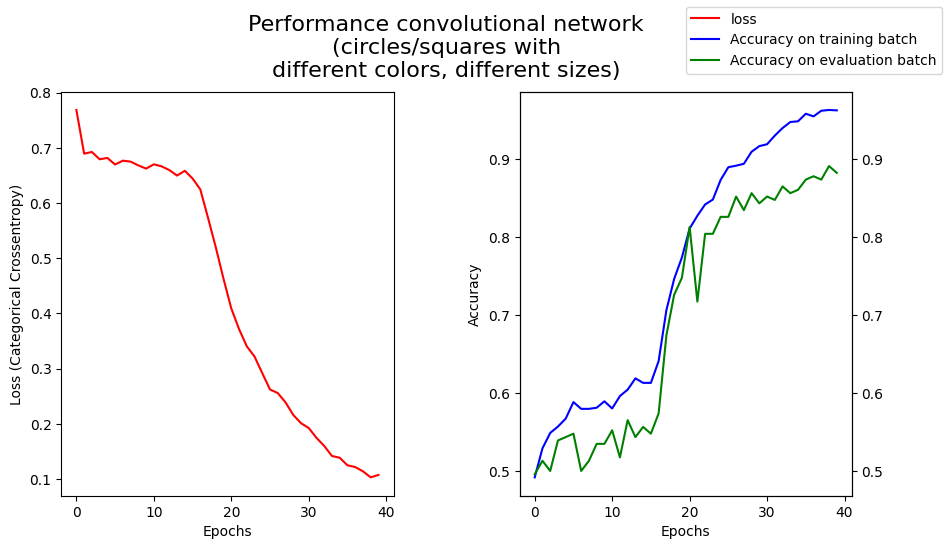

In [94]:
# Plotting loss-function and accuracy on training and evaluation batch. 
plt.rcParams["figure.figsize"] = [10, 6] # Defining figure size
fig, axs = plt.subplots(1, 2) # Plot contains two subplots
fig.tight_layout(pad=6) # For spacing between subplots

axs[0].set_ylabel('Loss (Categorical Crossentropy)') # left plot y-axis label
axs[0].set_xlabel('Epochs') # left plot x-axis label
axs[0].plot(history_4.history['loss'], color='red', label='loss') # plot loss-function in left figure

axs[1].set_ylabel('Accuracy') # right plot y-axis label
axs[1].set_xlabel('Epochs') # right plot x-axis label
ax2 = axs[1].twinx() # generate second axis to commonly plot accuracy on training and evaluation batch
ax2.sharey(axs[1]) # Both share y-axis
axs[1].plot(history_4.history['accuracy'], color='blue'
            , label='Accuracy on training batch') # Plot accuracy on training batch with blue color 
ax2.plot(history_4.history['val_accuracy'], color='green'
         , label='Accuracy on evaluation batch') # Plot accuracy on evaluation batch with green color
fig.suptitle('Performance convolutional network\n(circles/squares with\ndifferent colors, different sizes)', fontsize=16)
fig.legend()

Conclusion: Differenz sized squares and circles are slowing learning - even more than 30% noise.

# 4) Measuring size of squares

In [33]:
# Defining functions to preprocess area information
def area_preprocessing(target):
    target = np.array(target)[:, 2].astype('float')
    maximum = target.max()
    target /=  (maximum / 2)
    target -= 1
    return target, maximum

def inv_area_preprocessing(result, maximum):
    result += 1
    result /= 2
    result *= maximum
    return result.round(0).astype('int')

# Create samples and targets
samples_5, target_5 = samples_squares(2300, sq_size=[5, 30])
# Preprocessing: normalizing color values to values 0 to 1, 
samples_train_5 = preprocessing(samples_5)
# converting target_5 to array and normalizing to -1 to 1 values
target_train_5, target_max = area_preprocessing(target_5)


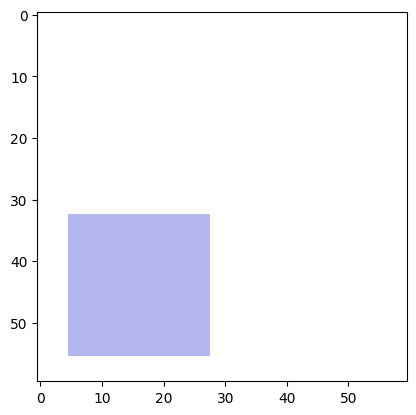

In [34]:
# Displaying exsample of data
plt.imshow(samples_5[5])

In [35]:
# Defining convolutional network
Net_conv5 = ks.Sequential()
Net_conv5.add(ks.layers.Conv2D(input_shape=(samples_5[0].shape), filters=20, kernel_size=[7, 7]
                              , activation='tanh', padding='same')) # Hidden layer conv. with kernel 7x7
Net_conv5.add(ks.layers.AveragePooling2D(pool_size=3)) # Hidden layer to reduce by factor of 3 each dimension
Net_conv5.add(ks.layers.Conv2D(filters=10, kernel_size=[5, 5] # Hidden layer conv. kernel 5x5
                              , activation='tanh', padding='same'))
Net_conv5.add(ks.layers.AveragePooling2D(pool_size=2)) # Hidden layer to reduce by factor of 3 each dimension
Net_conv5.add(ks.layers.Conv2D(filters=12, kernel_size=[5, 5] # Hidden layer conv. kernel 5x5
                              , activation='tanh', padding='same'))
Net_conv5.add(ks.layers.Flatten()) # Layer to flatten all convolutional filters, so dense layers can follow
Net_conv5.add(ks.layers.Dense(25, activation='tanh')) # Hidden dense layer
Net_conv5.add(ks.layers.Dense(1, activation='linear')) # Output layer: one hot encoding

Net_conv5.compile(optimizer='adam', loss='mean_squared_error', metrics=[ks.metrics.RootMeanSquaredError()])

In [37]:
history_5 = Net_conv5.fit(samples_train_5, target_train_5, batch_size=32,
                          validation_split=0.1, epochs=20)

Epoch 1/20


2023-04-08 17:33:58.823710: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 178848000 exceeds 10% of free system memory.


65/65 [==============================] - 7s 88ms/step - loss: 0.2624 - root_mean_squared_error: 0.5123 - val_loss: 0.1331 - val_root_mean_squared_error: 0.3648
Epoch 2/20
65/65 [==============================] - 5s 82ms/step - loss: 0.0578 - root_mean_squared_error: 0.2404 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1499
Epoch 3/20
65/65 [==============================] - 6s 94ms/step - loss: 0.0249 - root_mean_squared_error: 0.1576 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1486
Epoch 4/20
65/65 [==============================] - 5s 84ms/step - loss: 0.0189 - root_mean_squared_error: 0.1375 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952
Epoch 5/20
65/65 [==============================] - 5s 84ms/step - loss: 0.0106 - root_mean_squared_error: 0.1032 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 6/20
65/65 [==============================] - 5s 84ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.0138 - val_root_mean_squared

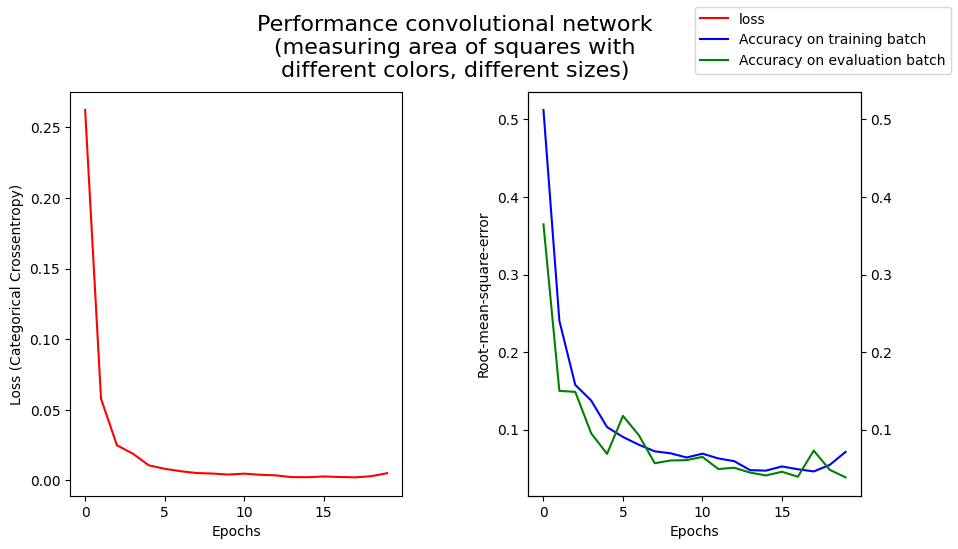

In [38]:
# Plotting loss-function and accuracy on training and evaluation batch. 
plt.rcParams["figure.figsize"] = [10, 6] # Defining figure size
fig, axs = plt.subplots(1, 2) # Plot contains two subplots
fig.tight_layout(pad=6) # For spacing between subplots

axs[0].set_ylabel('Loss (Categorical Crossentropy)') # left plot y-axis label
axs[0].set_xlabel('Epochs') # left plot x-axis label
axs[0].plot(history_5.history['loss'], color='red', label='loss') # plot loss-function in left figure

axs[1].set_ylabel('Root-mean-square-error') # right plot y-axis label
axs[1].set_xlabel('Epochs') # right plot x-axis label
ax2 = axs[1].twinx() # generate second axis to commonly plot accuracy on training and evaluation batch
ax2.sharey(axs[1]) # Both share y-axis
axs[1].plot(history_5.history['root_mean_squared_error'], color='blue'
            , label='Accuracy on training batch') # Plot accuracy on training batch with blue color 
ax2.plot(history_5.history['val_root_mean_squared_error'], color='green'
         , label='Accuracy on evaluation batch') # Plot accuracy on evaluation batch with green color
fig.suptitle('Performance convolutional network\n(measuring area of squares with\ndifferent colors, different sizes)', fontsize=16)
fig.legend()

In [41]:
# Generating new samples for validation on larger data set
validation_sample, validation_target_areas = samples_squares(5000, sq_size=[5, 30])

# Preprocessing: normalizing color values to values 0 to 1, 
# converting target_5 to array and normalizing to -1 to 1 values
validation_sample = preprocessing(validation_sample)
validation_target, validation_maximum = area_preprocessing(validation_target_areas)

y = Net_conv5.predict(validation_sample)

  5/157 [..............................] - ETA: 4s

2023-04-08 17:38:42.899672: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 432000000 exceeds 10% of free system memory.


157/157 [==============================] - 4s 28ms/step


Pearson-coefficient is: 0.998
P-value is: 0.00


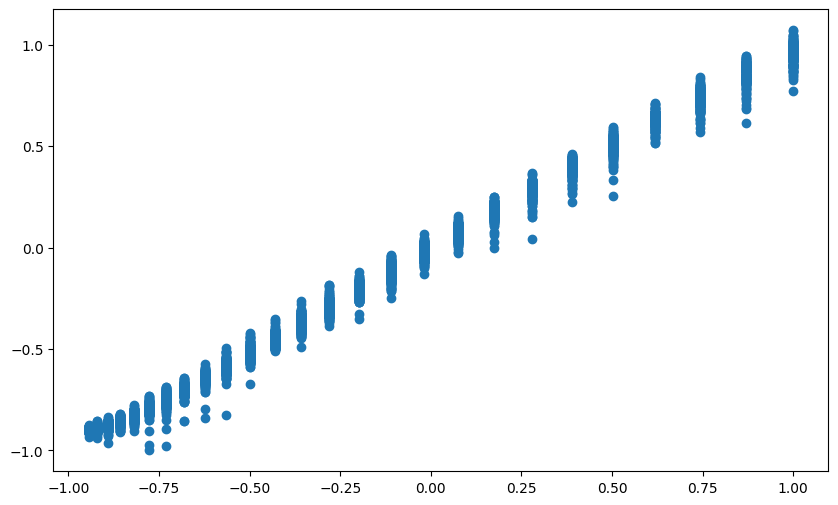

In [42]:
# Calculationg pearson correlation and p-value (for one-sided test for positive correlation)
pearson_result = sc.stats.pearsonr(validation_target.flatten(), y.flatten(), alternative='greater')
print(f'Pearson-coefficient is: {pearson_result.correlation:.3f}\nP-value is: {pearson_result.pvalue:.2f}')
# Displaying result of validation as scatter plot between true and estimate by network
plt.scatter(validation_target.flatten(), y.flatten())

Pearson-coefficient is: 0.998
P-value is: 0.00


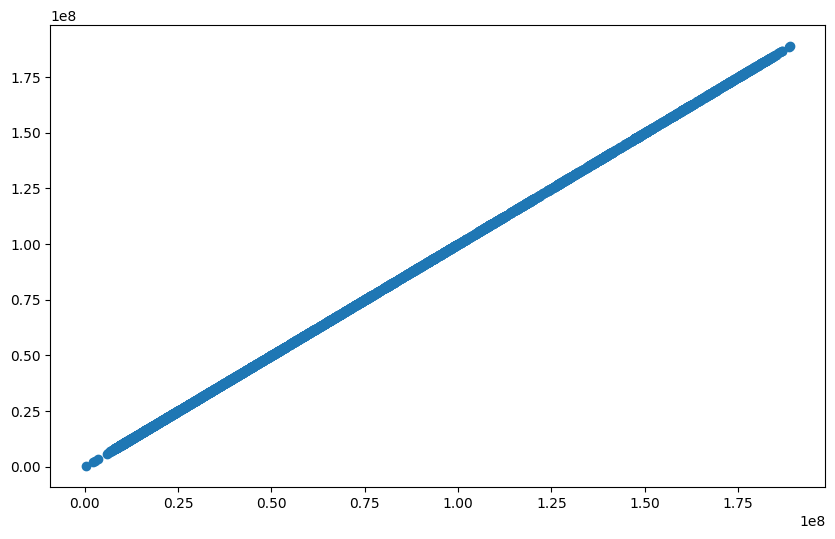

In [46]:
# Comparing on real area sizes
result_areas = inv_area_preprocessing(y, validation_maximum)
# Calculationg pearson correlation and p-value (for one-sided test for positive correlation)
pearson_result_areas = sc.stats.pearsonr(result_areas.flatten(), 
                                         result_areas.flatten(), alternative='greater')
print(f'Pearson-coefficient is: {pearson_result.correlation:.3f}\nP-value is: {pearson_result.pvalue:.2f}')
# Displaying result of validation as scatter plot between true and estimate by network
plt.scatter(result_areas.flatten(), result_areas.flatten())

In [48]:
validation_maximum

900.0